In [0]:
   %matplotlib inline

In [0]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from skimage import color, data, img_as_float, exposure
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing, dilation, black_tophat, disk, square, rectangle
from skimage import exposure
import math
from scipy import fftpack




def mostra_imagem_cinza(data, title):
  """Uma função auxiliar para exibir uma imagem em níveis de cinza"""
  f = plt.figure()
  ax_img = f.gca()
  ax_img.imshow(data, cmap=plt.cm.gray)
  ax_img.set_title(title)
  ax_img.set_axis_off()
  return (f, ax_img)

def mostra_histograma(data, num_particoes=256):
  """Uma função auxiliar para exibir o histograma de uma imagem
  
  num_particoes: número de partições do histograma 
  """
  f = plt.figure()
  ax_hist = f.gca()
  ax_hist.hist(data.ravel(), bins=num_particoes, histtype='step', color='black', linewidth=1.2)
  ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
  ax_hist.set_xlabel('Intensidade de pixel')
  return (f, ax_hist)


def aquisicao_Cinza(umaUrl):
  response = requests.get(umaUrl)
  img = np.array((Image.open(BytesIO(response.content))))
# red
  img_r = img[:, :, 0]
# green
  img_g = img[:, :, 1]
# blue
  img_b = img[:, :, 2]
  
  
  img_cinza1 = img_r.astype(np.float) *0.2125  + img_g.astype(np.float)*0.7174 + img_b.astype(np.float)*0.0721;

  return img_cinza1

def localiza_placa_MORF(umaUrl):

  img_cinza1 = aquisicao_Cinza(umaUrl)
  elem_estr_disco = disk(8)
  img_tophat = black_tophat(img_cinza1, elem_estr_disco)
  limiar = threshold_otsu(img_tophat)
  img_bin_otsu = img_tophat > limiar
  
  im_segment = morfo(img_bin_otsu) * img_cinza1

  return (im_segment)

def morfo(imagem):
  elem_estr_linea_vertr = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=np.uint8)
  img_fechamento = closing(imagem, elem_estr_linea_vertr)

  lem_estr_linear_vert1 = rectangle(15,1)
  elem_estr_linear_vert2 = rectangle(50,1)

  img_abertura1 = img_as_float(opening(img_fechamento, elem_estr_linear_vert1))
  img_abertura2 = img_as_float(opening(img_abertura1, elem_estr_linear_vert2))

  img_subtracao = img_abertura1 - img_abertura2
  elem_estr_linear_horiz3 = rectangle(1,80)
  img_abert_limpa = opening(img_subtracao, elem_estr_linear_horiz3)

  elem_estr_quadrado1 = square(30)
  img_segmet = dilation(img_abert_limpa, elem_estr_quadrado1)
  
  return (img_segmet)

 


def Pre_Eq_Hist(umaUrl):

  img_cinza1 = aquisicao_Cinza(umaUrl)
  img_eq = equaliza_Hist(img_cinza1)

  elem_estr_disco = disk(8)
  img_tophat = black_tophat(img_eq, elem_estr_disco)
  limiar = threshold_otsu(img_tophat)
  img_bin_otsu = img_tophat > limiar
  img_segmet = morfo(img_bin_otsu)
  
  return (img_segmet*img_cinza1)

def equaliza_Hist(imagemcinza):
  return exposure.equalize_hist(imagemcinza)


def Pre_filtro_PassaBaixa(umaUrl):
  img_cinza1 = aquisicao_Cinza(umaUrl)
  img_filter = aplicaFF(img_cinza1)
  
  elem_estr_disco = disk(8)
  img_tophat = black_tophat(img_filter, elem_estr_disco)
  limiar = threshold_otsu(img_tophat)
  img_bin_otsu = img_tophat > limiar
  img_segmet = morfo(img_bin_otsu)
  return (img_segmet*img_cinza1)

def Pre_filtro_Homorfico(umaUrl):
  img_cinza1 = aquisicao_Cinza(umaUrl)
  img_filter = filtro_Homorfico(img_cinza1)

  elem_estr_disco = disk(8)
  img_tophat = black_tophat(img_filter, elem_estr_disco)
  limiar = threshold_otsu(img_tophat)
  img_bin_otsu = img_tophat > limiar
  img_segmet = morfo(img_bin_otsu)
  return (img_segmet*img_cinza1)

  

def butterworth_passa_baixa(dimensao, wcorte, n):
  """Cria um filtro de Butterworth passa baixa no domínio da frequência.

  dimensao: largura do filtro (o filtro criado é quadrado dimensao x dimensao)
  wcorte: frequência de corte do filtro, medido em pixels
  n: numero inteiro positivo (n  >= 1); grau do polinômio do filtro; quanto maior n,
     mais abrupta é a transicao do filtro
  """
  filtro = np.zeros((dimensao, dimensao), dtype=float)
  xidx = np.arange(dimensao)
  yidx = np.arange(dimensao)
  x0, y0 = dimensao//2, dimensao//2
  xx, yy = np.meshgrid(xidx, yidx, indexing='ij')
  dist = np.sqrt(((xx-x0)**2 + (yy-y0)**2))
  ratio = dist/wcorte
  c = 2**n
  filtro = 1/(1 + ratio**c) 
  return filtro
  
def preencher(matriz, linhas=-1, colunas=-1):
  """Cria uma nova matriz, de dimensoes maiores que a matriz passada como entrada, e preenchendo os novos
  elementos com zero.

  matriz: matriz de entrada
  linhas: número de linhas da nova imagem
  colunas: número de colunas da nova imagem

  """
  rows, cols = matriz.shape
  if(linhas < 0 and colunas < 0):
      linhas, colunas = (2*rows, 2*cols)
  if(rows > linhas or cols > colunas):
      raise ValueError("Novas dimensões (%d, %d) são menores que as anteriores (%d, %d)" % (linhas, colunas, rows, cols))
  res = np.zeros((linhas, colunas), dtype=matriz.dtype)
  res[0:rows, 0:cols] = matriz
  return res
  
def plot_spectrum(im_fft):
  from matplotlib.colors import LogNorm
  # A logarithmic colormap
  plt.imshow(np.abs(im_fft), cmap='PuBu_r', norm=LogNorm(vmin=5))
  plt.colorbar()

  
  
def deslocamento_freq(rows, cols):
  xidx = np.arange(rows)
  yidx = np.arange(cols)
  xx, yy = np.meshgrid(xidx, yidx, indexing='ij')
  grade = -np.ones((rows, cols))
  # em python a**b significa "a elevado a b"
  mascara = grade**(xx+yy)
  return mascara
  
def aplicaFF(imagemcinza):
  impad = preencher(imagemcinza, 1024, 1024)
  mascara_deslocamento = deslocamento_freq(1024,1024)
  
  im_desloca = impad*mascara_deslocamento
  
  im_fft_centralizada = fftpack.fft2(im_desloca)

  f = plt.figure(figsize=(12, 8))
  f.gca().set_axis_off()
  #plot_spectrum(im_fft_centralizada)
  #plt.title('Espectro de Fourier (logaritmo do modulo)');

  filtro_freq = butterworth_passa_baixa(1024, 200, 2)
  #mostra_imagem_cinza(filtro_freq, "filtro")
  fft_fpb = filtro_freq*im_fft_centralizada
  im_filtrada_desloca = fftpack.ifft2(fft_fpb).real
  im_filtrada = im_filtrada_desloca*mascara_deslocamento
  linhas, colunas = imagemcinza.shape
  
  im1 = im_filtrada[0:linhas, 0:colunas]
  return (im1)

def filtro_Homorfico(img1):
  img = replaceZeroes(img1)
  img_log = np.log10((img))
  img_fft = aplicaFF(img_log)
  im_norm = normalize(img_fft)
  img_exp = np.exp(im_norm)
  im_norm1 = normalize(img_exp)
  return (im_norm1)

def normalize(v):
  norm=np.linalg.norm(v, ord=1)
  if norm==0:
      norm=np.finfo(v.dtype).eps
  return v/norm

def replaceZeroes(data):
  min_nonzero = np.min(data[np.nonzero(data)])
  data[data == 0] = min_nonzero
  return data

def imprimeImagens(url):
  im1 = aquisicao_Cinza(teste)

  fig, axes = plt.subplots(2, 2, figsize=(7, 6))
  ax = axes.ravel()

  ax[0].imshow(localiza_placa_MORF(teste),cmap=plt.cm.gray)
  ax[0].set_title("Localizacao sem pre processamento")

  ax[1].imshow(Pre_Eq_Hist(teste), cmap=plt.cm.gray)
  ax[1].set_title("Localizacao apos equalizacao de histograma")

  ax[2].imshow(Pre_filtro_PassaBaixa(teste), cmap=plt.cm.gray)
  ax[2].set_title("Localizacao apos Filtro passa baixa butterworth")

  ax[3].imshow(Pre_filtro_Homorfico(teste), cmap=plt.cm.gray)
  ax[3].set_title("Localizacao apos Filtro Homorfico")

  for a in ax.ravel():
    a.axis('off')

  fig.tight_layout();




## Endereços das imagens para casos de teste


In [0]:
################################## EXITO ########################################
url1 = "http://www.pc.rs.gov.br/upload/HD_20110620165315_cod14299.jpg"
url2 = "https://www.bocaonews.com.br/ckfinder/userfiles/fotos_e_imagens/POLICIA/PRESOS-E-ACUSADOS/foto(18).JPG"
url3 = "https://i1.wp.com/www.ecoacre.net/wp-content/uploads/2017/12/IMG-20171219-WA0411.jpg?resize=480%2C640"
url4 = "https://www.metro1.com.br/noticias/36336,carro-de-engenheiro-desaparecido-e-encontrado-em-simoes-filho-3.jpg"
url5 ="http://www.goionews.com.br/gthumb.php?src=./bdimages/20141113/santa%20f%C3%A92.jpg&w=400&h=400"

############################## EXITO POS PROCESSAMENTO####################################
url6 = "https://2.bp.blogspot.com/-uCq7mY-bjxo/WNZ5DJuMJCI/AAAAAAAA-qY/IDLjNIGamcMLEu621rxMafpRhmWlRe9-gCLcB/s1600/classic.jpg"

################################## FALHA  ######################################
url7 = "http://dia.portalodia.com/media/editor/2016-06-07-photo-000000171465305843.jpg"
url8 = "http://www.tvcanal13.com/images/prf-apreende-caminhao-com-placa-clonada-no-interior-do-piaui-304095.jpg"
url9 = "https://cdn.massanews.com/uploads/noticias/lg-dbe62908-20e2-4ce6-b9ad-20386051f3d1.jpeg"
url10 = "http://s2.glbimg.com/eiu2ZKV-PqwpBy5d-YSUvoZuI3A=/620x465/s.glbimg.com/jo/g1/f/original/2016/05/16/taxi-preto.jpg"


url11 = "https://www.flatout.com.br/wp-content/uploads/2017/11/IMG_1897-1.jpg"
url12 = "https://www.flatout.com.br/wp-content/uploads/2016/02/2o-classicos-brasil-2016-flatout-91.jpg"
url13 = "https://www.flatout.com.br/wp-content/uploads/2017/11/TR_Lava_Jato_Foto_Tania_Rego00105242016.jpg"
url14 = "https://www.flatout.com.br/wp-content/uploads/2017/11/cur_taxi_bike13102015_145.jpg"
url15 = "https://www.flatout.com.br/wp-content/uploads/2017/11/FlatOut-2017-11-07-%C3%A0s-19.45.26.jpg"

url16 = "http://s2.glbimg.com/qpvBQ3SzS_6xsrRw7b4WMDqPmec=/300x225/s.glbimg.com/jo/g1/f/original/2013/11/13/corsa_placa_certa_12-11-13.jpg"
url17 = "https://www.portalcbncampinas.com.br/wp-content/uploads/2017/08/a5edc240-7736-408e-9851-a1470bd9598d-696x522.jpg"
url18= "http://www.fatonovo.com.br/arquivos/cache/sandero-com-placas-clonadas-trafegava-em-excesso-de-velocidade-mas-multa-foi-para-carro-original--fo-crop_370_370_30333_sanderoclonado.jpg"
url19 = "http://fotos.jornaldocarro.estadao.com.br/jornal-do-carro/imagens/noticia/TRANSITO-1.jpg"
url20 = "http://www.potencialpetroleo.com.br/wp/wp-content/uploads/2014/07/NEBLINA-610x215.jpg"


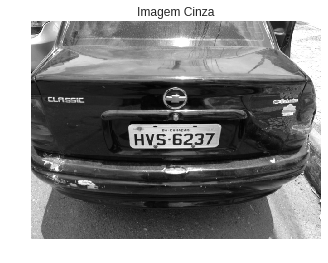

In [603]:

#aquisição
response = requests.get(url2)
img = np.array((Image.open(BytesIO(response.content))))
#img = np.array(Image.open(StringIO(response.content)))


#Convertendo para niveis de cinza
#Para evitar overflow 

# red
img_r = img[:, :, 0]
# green
img_g = img[:, :, 1]
# blue
img_b = img[:, :, 2]

img_cinza1 = img_r.astype(np.float) *0.2125  + img_g.astype(np.float)*0.7174 + img_b.astype(np.float)*0.0721;

mostra_imagem_cinza(img_cinza1, 'Imagem Cinza');




##Agora, vamos realizar a operação de morfologia matemática *tophat* por fechamento


O elemento estruturante será um disco de 10 mm de diametro,ie, 5 mm de raio, valor oficial da espessura dos caracteres das placas

link importante: < http://www.eripi.com.br/2017/images/anais/minicursos/8.pdf >


## Agora, vamos eliminar as areas falsas da imagem 

Tais areas não tem grande potencial para apresentar a presença da placa

Usaremos o metodo de Otsu para a limiarização da imagem

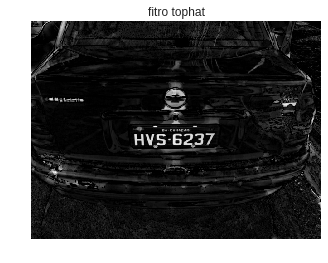

In [604]:
elem_estr_disco = disk(8)
img_tophat = black_tophat(img_cinza1, elem_estr_disco)
mostra_imagem_cinza(img_tophat, 'fitro tophat');

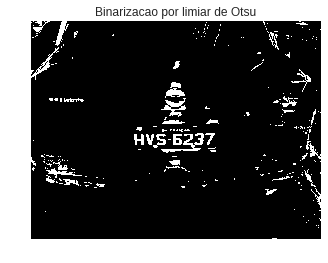

In [605]:
limiar = threshold_otsu(img_tophat)
img_bin_otsu = img_tophat > limiar
mostra_imagem_cinza(img_bin_otsu, 'Binarizacao por limiar de Otsu');


## Faremos o inicio da segmentação da placa na imagem

Inicialmente, aplicamos a operação de fechamento na imagem binarizada, com elemento estruturante horizontal linear ,
com comprimento igual a maior separação entre os caracteres possivel.
Esperamos obter um retangulo branco na região da placa

Por tentativa e erro, chegamos ao comprimento ideal de separação, devido a grande diversidade do formato dos caracteres.







(<matplotlib.figure.Figure at 0x7f32763c1630>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f32763b1b38>)

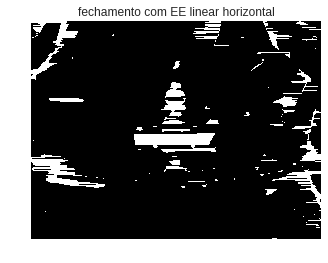

In [606]:
elem_estr_linea_vertr = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=np.uint8)
img_fechamento = closing(img_bin_otsu, elem_estr_linea_vertr)
mostra_imagem_cinza(img_fechamento, 'fechamento com EE linear horizontal')


## O proximo passo consiste em realizar a Abertura Horizontal e depois a Abertura Vertical. 
Para isso, devemos saber as dimensões maximas e minimas que ocorrem nos caracteres.



*   altura minima = 63 mm e largura minima = 10 mm (caracter 'I')
*   altura máxima = 63 mm e largura máxima = 54 mm (caracter 'A')



Faremos  uma  abertura  com  um  elemento estruturante vertical linear, para eliminarmos os objetos de altura inferior à altura mínima dos caracteres, ie o  EE será uma barra vertical de 63 mm.

Após isso, repetimos a operação de abertura para eliminar os objetos de altura inferior a altura   máxima   dos   
caracteres.  Esperamos que nessa etapa, a placa também seja eliminada propositalmente.

Vamos então subrtrair  à 1º imagem do passo anterior da 2º. Visamos obter uma imagem que conterá apenas a placa e um pouco de ruído residual



---
Para eliminira este ruído residual, aplicamos uma abertura  com  um  
elemento estruturante horizontal linear de largura menor do que a largura mínima da placa - 360 mm a saber

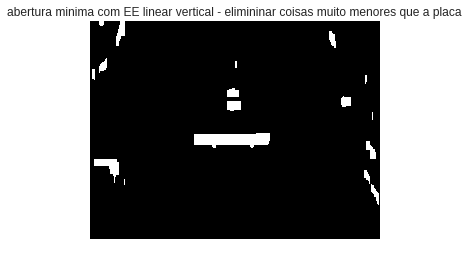

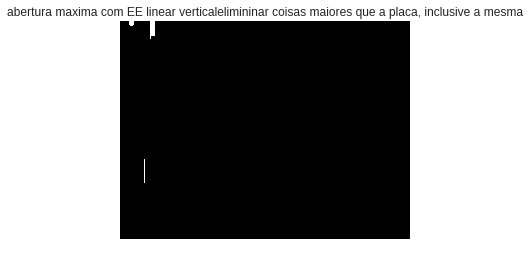

In [607]:
elem_estr_linear_vert1 = rectangle(15,1)
elem_estr_linear_vert2 = rectangle(50,1)



img_abertura1 = img_as_float(opening(img_fechamento, elem_estr_linear_vert1))
mostra_imagem_cinza(img_abertura1, 'abertura minima com EE linear vertical - elimininar coisas muito menores que a placa');

img_abertura2 = img_as_float(opening(img_abertura1, elem_estr_linear_vert2))
mostra_imagem_cinza(img_abertura2, 
                    'abertura maxima com EE linear vertical'+
                     'elimininar coisas maiores que a placa, inclusive a mesma');


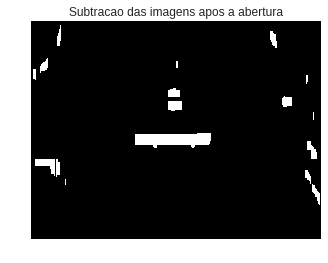

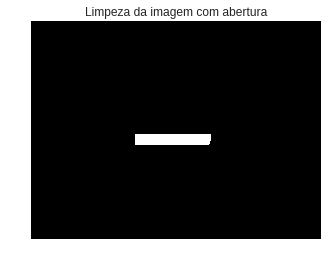

In [608]:
img_subtracao = img_abertura1 - img_abertura2
mostra_imagem_cinza(img_subtracao,'Subtracao das imagens apos a abertura')
elem_estr_linear_horiz3 = rectangle(1,80)
#tamanho da placa
img_abert_limpa = opening(img_subtracao, elem_estr_linear_horiz3)
mostra_imagem_cinza(img_abert_limpa,'Limpeza da imagem com abertura');





## Precisamos garantir que a placa inteira seja segmentada

Assim, aplicamos uma dilatação para "engordar" a região que parece conter uma placa

---

Com esta "forma" podemos então destacar a área da placa da imagem inicial com o veículo.


A imagem final mostra a placa segmentada, conforme o esperado para identificá-la.

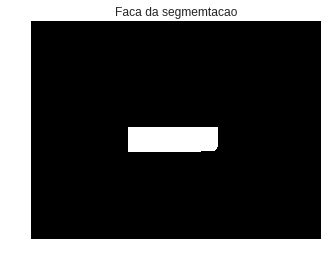

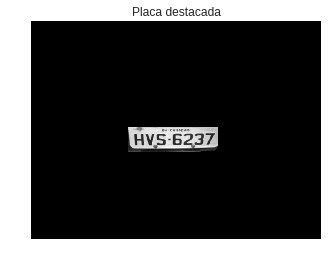

In [609]:
elem_estr_quadrado1 = square(30)
img_segmet = dilation(img_abert_limpa, elem_estr_quadrado1)
mostra_imagem_cinza(img_segmet, 'Faca da segmemtacao')
mostra_imagem_cinza(img_segmet * img_cinza1, 'Placa destacada');



## Feito isso, vamos aplicar o método em alguns exemplos

Propomos 3 métodos para o pré processamento das imagens.


*  Equalização de Histograma
*  Filtragem Passa Baixa
*  Filtragem Homorfica

Para realizar os testes, basta trocar o valor da variavel  'teste' para um valor de url válido.

Podemos analisar os diferentes resultados de localização por morfologia matematica perante diferentes técnicas de pre-processamento
URL VALIDAS E TESTADAS:
url1, url2, url3....url20


---


**algumas imagens encontradas para teste estão apresentando um erro na filtragem Homorfica (na transformação Logaritmica) que não foi resolvido**


Report do erro : ValueError: range parameter must be finite.



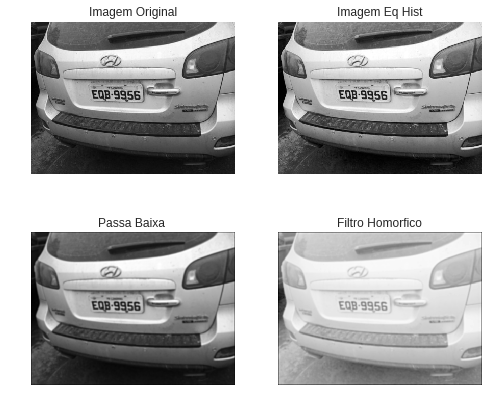

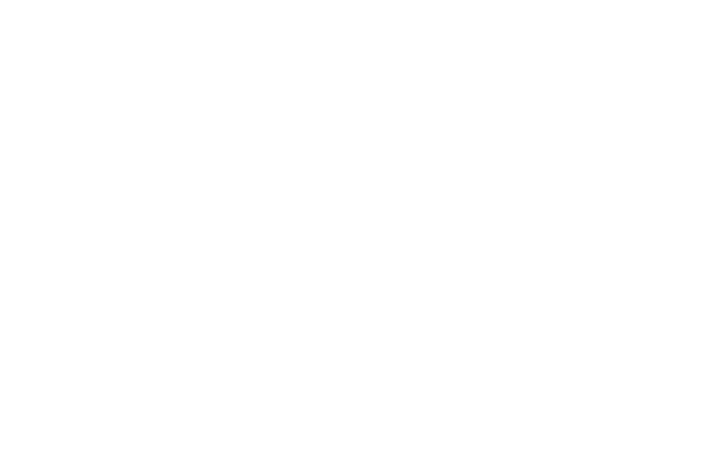

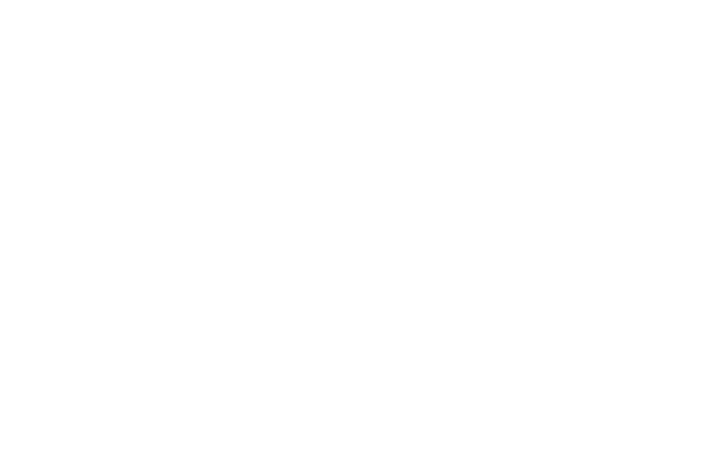

In [640]:

teste = url5
im1 = aquisicao_Cinza(teste)


fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax = axes.ravel()
try:
  
  ax[0].imshow(aquisicao_Cinza(teste),cmap=plt.cm.gray)
  ax[0].set_title("Imagem Original")

  ax[1].imshow(equaliza_Hist(im1), cmap=plt.cm.gray)
  ax[1].set_title("Imagem Eq Hist")

  ax[2].imshow(aplicaFF(im1), cmap=plt.cm.gray)
  ax[2].set_title("Passa Baixa ")
  ax[3].imshow(filtro_Homorfico(im1), cmap=plt.cm.gray)
  ax[3].set_title("Filtro Homorfico")

  for a in ax.ravel():
    a.axis('off')
  
  fig.tight_layout()
except ValueError:
    print ("Oops!  Erro na aplicação do filtro homomorfico - ")
      


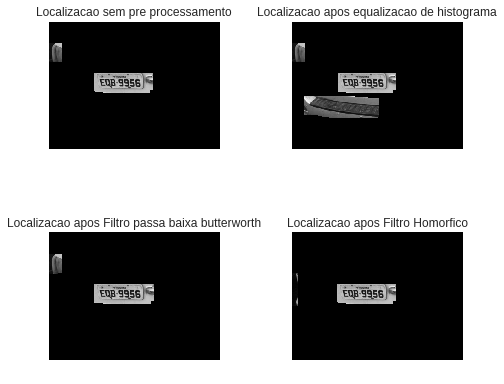

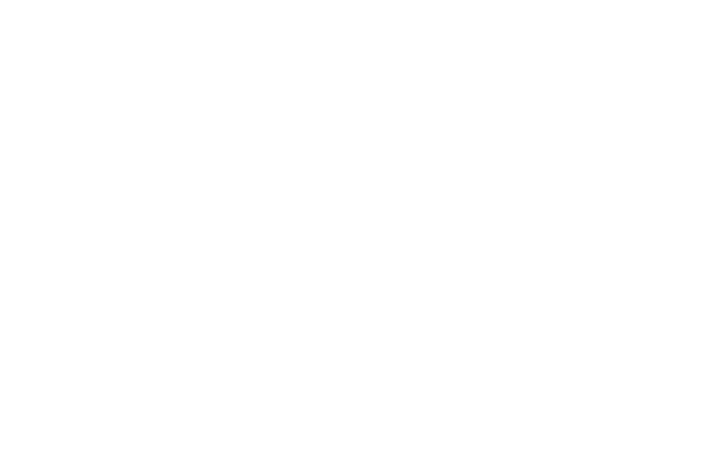

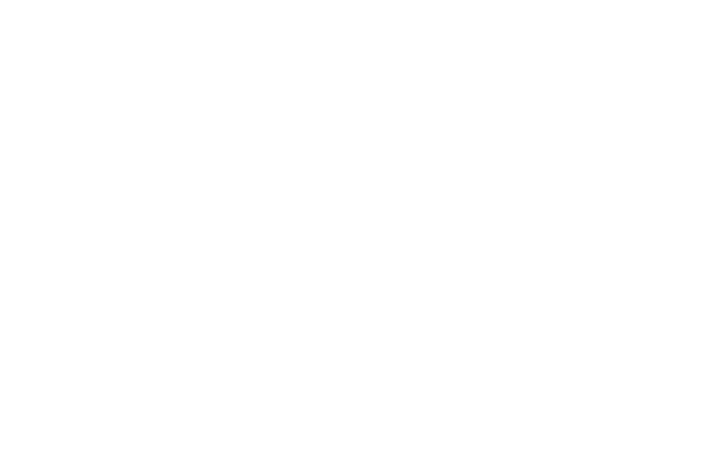

In [641]:
  fig, axes = plt.subplots(2, 2, figsize=(7, 6))
  ax = axes.ravel()

  ax[0].imshow(localiza_placa_MORF(teste),cmap=plt.cm.gray)
  ax[0].set_title("Localizacao sem pre processamento")

  ax[1].imshow(Pre_Eq_Hist(teste), cmap=plt.cm.gray)
  ax[1].set_title("Localizacao apos equalizacao de histograma")

  ax[2].imshow(Pre_filtro_PassaBaixa(teste), cmap=plt.cm.gray)
  ax[2].set_title("Localizacao apos Filtro passa baixa butterworth")

  ax[3].imshow(Pre_filtro_Homorfico(teste), cmap=plt.cm.gray)
  ax[3].set_title("Localizacao apos Filtro Homorfico")

  for a in ax.ravel():
    a.axis('off')

  fig.tight_layout();


